# Set Up

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [95]:
from sklearn.model_selection import train_test_split

In [2]:
engagement_df = pd.read_csv('takehome_user_engagement.csv')

In [3]:
engagement_df.shape

(207917, 3)

In [4]:
engagement_df.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


Okay, so we want to make a column in the users df, that lists the number of unique visits for each user. Unique visits are entries in the engagement df.

In [5]:
engagement_df[engagement_df.user_id == 2]

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1
10,2014-02-13 03:45:04,2,1


In [6]:
engagement_df.visited.value_counts()

1    207917
Name: visited, dtype: int64

# Adoption Exporation

In [7]:
engagement_df.user_id.value_counts(sort=True, ascending=True).head(20)

2047     1
10040    1
5822     1
3773     1
6763     1
7743     1
5694     1
1596     1
11833    1
10861    1
3901     1
5566     1
1468     1
11705    1
9656     1
7487     1
5438     1
4842     1
11577    1
872      1
Name: user_id, dtype: int64

In [8]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [9]:
users_df.shape

(12000, 10)

In [10]:
users_df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [11]:
users_df.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [12]:
users_df.object_id.value_counts()

2049     1
10912    1
661      1
6806     1
4759     1
        ..
7481     1
1338     1
3387     1
9534     1
2047     1
Name: object_id, Length: 12000, dtype: int64

In [13]:
In [36]: engagement_df.groupby(["user_id"]).count().sort_values(["visited"], ascending=False)

,time_stamp,visited
user_id,,
3623,606,606
906,600,600
1811,593,593
7590,590,590
8068,585,585
...,...,...
4699,1,1
4698,1,1
4697,1,1


In [14]:
user_visits = engagement_df.groupby(["user_id"]).count()

In [15]:
user_visits.head(3)

,time_stamp,visited
user_id,,
1,1,1
2,14,14
3,1,1


In [16]:
user_visits = user_visits.reset_index()

In [17]:
user_visits.head(5)

,user_id,time_stamp,visited
0,1,1,1
1,2,14,14
2,3,1,1
3,4,1,1
4,5,1,1


In [18]:
test = int(user_visits.loc[user_visits['user_id'] == 2].visited)

In [19]:
print(test)
type(test)

14


int

# Manufacture of adopted user column

In [20]:
def count_adder(value):
    visit_count = 0
    try:
        visit_count = int(user_visits.loc[user_visits['user_id'] == value].visited)
    except TypeError:
        return 0
    if visit_count >= 3:
        return 1
    return 0
    
    
    
    

In [21]:
users_df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [22]:
user_visits.visited.value_counts().head(25)

1     6235
2      340
3      241
4      181
5      110
6       85
7       68
8       57
9       48
10      34
14      30
13      29
12      29
11      26
22      23
16      20
25      19
17      18
23      18
18      18
20      16
24      15
26      15
21      15
27      13
Name: visited, dtype: int64

This is good, but needs to account for it being within a 7 day period

In [23]:
engagement_df['atemp_adopted_user'] = engagement_df.user_id.apply(count_adder)

In [24]:
engagement_df.head(20)

,time_stamp,user_id,visited,atemp_adopted_user
0,2014-04-22 03:53:30,1,1,0
1,2013-11-15 03:45:04,2,1,1
2,2013-11-29 03:45:04,2,1,1
3,2013-12-09 03:45:04,2,1,1
4,2013-12-25 03:45:04,2,1,1
5,2013-12-31 03:45:04,2,1,1
6,2014-01-08 03:45:04,2,1,1
7,2014-02-03 03:45:04,2,1,1
8,2014-02-08 03:45:04,2,1,1
9,2014-02-09 03:45:04,2,1,1


In [25]:
adoptee_df = engagement_df[engagement_df.atemp_adopted_user > 0]

In [26]:
print(adoptee_df.shape)
adoptee_df.head(10)

(201002, 4)


,time_stamp,user_id,visited,atemp_adopted_user
1,2013-11-15 03:45:04,2,1,1
2,2013-11-29 03:45:04,2,1,1
3,2013-12-09 03:45:04,2,1,1
4,2013-12-25 03:45:04,2,1,1
5,2013-12-31 03:45:04,2,1,1
6,2014-01-08 03:45:04,2,1,1
7,2014-02-03 03:45:04,2,1,1
8,2014-02-08 03:45:04,2,1,1
9,2014-02-09 03:45:04,2,1,1
10,2014-02-13 03:45:04,2,1,1


In [27]:
len(adoptee_df.user_id.unique())

2248

In [28]:
len(engagement_df.user_id.unique())

8823

In [29]:
adoptee_df['datetime'] = pd.to_datetime(adoptee_df['time_stamp'])

<ipython-input-29-55e2eb7751f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adoptee_df['datetime'] = pd.to_datetime(adoptee_df['time_stamp'])


In [30]:
adoptee_df.datetime.iloc[1]

Timestamp('2013-11-29 03:45:04')

In [31]:
adoptee_df.datetime.iloc[1]-adoptee_df.datetime.iloc[2]

Timedelta('-10 days +00:00:00')

In [32]:
adoptee_df.user_id.unique()

array([    2,    10,    20, ..., 11981, 11988, 11991], dtype=int64)

In [33]:
potential_dict = {}
for each in adoptee_df.user_id.unique():
    potential_dict[each] = []

In [34]:
#This is looking good, just need to explore how to add these values to the list inside the dictionary
potential_dict[2]

adoptee_df.datetime[engagement_df.user_id == 2]

1    2013-11-15 03:45:04
2    2013-11-29 03:45:04
3    2013-12-09 03:45:04
4    2013-12-25 03:45:04
5    2013-12-31 03:45:04
6    2014-01-08 03:45:04
7    2014-02-03 03:45:04
8    2014-02-08 03:45:04
9    2014-02-09 03:45:04
10   2014-02-13 03:45:04
11   2014-02-16 03:45:04
12   2014-03-09 03:45:04
13   2014-03-13 03:45:04
14   2014-03-31 03:45:04
Name: datetime, dtype: datetime64[ns]

In [35]:
type(adoptee_df.datetime[engagement_df.user_id == 2])

pandas.core.series.Series

In [36]:
for each in adoptee_df.datetime[engagement_df.user_id == 2]:
    potential_dict[2].append(each)

In [37]:
potential_dict[2]

[Timestamp('2013-11-15 03:45:04'),
 Timestamp('2013-11-29 03:45:04'),
 Timestamp('2013-12-09 03:45:04'),
 Timestamp('2013-12-25 03:45:04'),
 Timestamp('2013-12-31 03:45:04'),
 Timestamp('2014-01-08 03:45:04'),
 Timestamp('2014-02-03 03:45:04'),
 Timestamp('2014-02-08 03:45:04'),
 Timestamp('2014-02-09 03:45:04'),
 Timestamp('2014-02-13 03:45:04'),
 Timestamp('2014-02-16 03:45:04'),
 Timestamp('2014-03-09 03:45:04'),
 Timestamp('2014-03-13 03:45:04'),
 Timestamp('2014-03-31 03:45:04')]

In [38]:
for key in potential_dict.keys():
    for each in adoptee_df.datetime[engagement_df.user_id == key]:
        potential_dict[key].append(each)

In [39]:
potential_dict[2][1] -  potential_dict[2][2]

Timedelta('-10 days +00:00:00')

In [40]:
datetime.timedelta(days=0)

datetime.timedelta(0)

In [41]:
def adoption_checker(listo):
    delta = datetime.timedelta(days=7)
    zero_point = datetime.timedelta(days=0)
    
    for each in listo:
        consecutive_list = []
        consecutive_list.append(each)

        for second_each in listo:
            subtraction = second_each - consecutive_list[0]
            
            if subtraction < delta and subtraction > zero_point:
                consecutive_list.append(second_each)
                
                if len(consecutive_list) >= 3:
                    return True
                
            elif second_each - consecutive_list[0] > delta: 
                break
        
                
    return False
            
            
    

In [42]:
#this looks like it works. Just gotta check user 11981 to make sure they are in fact not consecutive

In [43]:
adoption_checker(potential_dict[2])

True

In [44]:
adoption_checker(potential_dict[11981])

False

In [45]:
potential_dict[11981]

[Timestamp('2013-03-06 01:53:48'),
 Timestamp('2013-03-21 01:53:48'),
 Timestamp('2013-03-25 01:53:48'),
 Timestamp('2013-04-02 01:53:48')]

In [46]:
#okay, this looks like the outputs are right.

In [47]:
test_dict = {}
test_dict[2] = potential_dict[2]
test_dict[20] = potential_dict[11981]
for key, value in test_dict.items():
    print(key, adoption_checker(value))

2 True
20 False


In [48]:
#still gets correct outputs when working with multiple consecutive usages

In [49]:
#Excellent, the function is functioning!

In [50]:
actual_adoptees = {}
for key, value in potential_dict.items():
    actual_adoptees[key] =  adoption_checker(value)
    

In [51]:
actual_adoptees

{2: True,
 10: True,
 20: True,
 33: True,
 42: True,
 43: True,
 50: True,
 53: True,
 59: False,
 60: False,
 63: True,
 69: True,
 74: True,
 77: False,
 80: True,
 81: True,
 82: True,
 87: True,
 95: False,
 126: False,
 133: True,
 135: True,
 136: False,
 141: True,
 142: False,
 146: True,
 153: True,
 160: True,
 165: True,
 168: True,
 171: False,
 172: True,
 174: True,
 185: True,
 188: True,
 197: True,
 200: True,
 202: True,
 203: True,
 209: True,
 214: True,
 221: False,
 230: True,
 241: False,
 245: True,
 247: True,
 251: False,
 263: True,
 265: True,
 275: True,
 277: False,
 280: True,
 283: True,
 297: True,
 298: True,
 305: True,
 310: True,
 311: True,
 321: True,
 322: True,
 330: False,
 337: False,
 341: True,
 345: False,
 347: True,
 351: True,
 362: False,
 363: True,
 367: False,
 370: True,
 375: False,
 382: False,
 383: True,
 390: False,
 397: True,
 398: False,
 401: True,
 417: False,
 418: True,
 430: True,
 445: True,
 450: True,
 455: False,
 

In [52]:
adoption_df = pd.DataFrame([actual_adoptees])

In [53]:
adoption_df =adoption_df.transpose()

In [54]:
adoption_df = adoption_df.reset_index()

In [55]:
adoption_df['user_id'] = adoption_df['index']

In [56]:
adoption_df = adoption_df.drop(columns=['index'])

In [57]:
adoption_df

,0,user_id
0,True,2
1,True,10
2,True,20
3,True,33
4,True,42
...,...,...
2243,True,11975
2244,False,11980
2245,False,11981
2246,True,11988


In [58]:
adoption_df['object_id'] =adoption_df['user_id']

In [59]:
adoption_df['adoption_status'] =adoption_df[0]

In [60]:
adoption_df= adoption_df.drop(columns=[0, 'user_id'])

In [61]:
adoption_df

,object_id,adoption_status
0,2,True
1,10,True
2,20,True
3,33,True
4,42,True
...,...,...
2243,11975,True
2244,11980,False
2245,11981,False
2246,11988,True


In [62]:
users_df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [63]:
users_df=users_df.merge(adoption_df, on='object_id', how='left') 

In [64]:
print(users_df.shape)
print(users_df.adoption_status.isna().sum())
print(users_df.adoption_status.value_counts())
print(users_df.adoption_status)

(12000, 11)
9752
True     1602
False     646
Name: adoption_status, dtype: int64
0         NaN
1        True
2         NaN
3         NaN
4         NaN
         ... 
11995     NaN
11996     NaN
11997     NaN
11998     NaN
11999     NaN
Name: adoption_status, Length: 12000, dtype: object


In [65]:
users_df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoption_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True


In [66]:
users_df.adoption_status.fillna(value=False, inplace=True)

In [67]:
print('shape of total df')
print(users_df.shape)
print('sum of NA values')
print(users_df.adoption_status.isna().sum())
print(users_df.adoption_status.value_counts())
print(users_df.adoption_status)

shape of total df
(12000, 11)
sum of NA values
0
False    10398
True      1602
Name: adoption_status, dtype: int64
0        False
1         True
2        False
3        False
4        False
         ...  
11995    False
11996    False
11997    False
11998    False
11999    False
Name: adoption_status, Length: 12000, dtype: bool


# EDA

In [68]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adoption_status             12000 non-null  bool   
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 1.0+ MB


In [69]:
users_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


# PreProcessing

### Time Conversions


https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date


It is really important to differentiate the data types that you want to use for regression/classification.

When you are using time series, that is another case but if you want to use time data as a numerical data type as your input, then you should transform your data type from datetime to float (if your data_df['conv_date] is a datetime object, if not then you should first transform it by using; data_df['conv_date'] = pd.to_datetime(data_df.date, format="%Y-%M-%D") )

I agree with Thomas Vetterli's answer. It is useful to be careful what kind of time data you are using.

If you are only using year and month data then dt.datetime.toordinal would be enough to use;

>import datetime
>data_df['conv_date'] = pd.to_datetime(data_df.date, format="%Y-%M-%D")
>data_df['conv_date'] = data_df['conv_date'].map(datetime.datetime.toordinal)
737577
But if you want to use also the hour, minute and second information then time.mktime() suits better;

>import time
>data_df['conv_date'] = pd.to_datetime(data_df.date, format="%Y-%M-%D")
>data_df['conv_date'] = data_df['conv_date'].apply(lambda  var: time.mktime(var.timetuple()))
1591016041.0 

Also 1591016044.0 is another exemplary output from my data, it varies with changes in seconds.

In [70]:
users_df.creation_time = pd.to_datetime(users_df.creation_time)


In [71]:
users_df.creation_time

0       2014-04-22 03:53:30
1       2013-11-15 03:45:04
2       2013-03-19 23:14:52
3       2013-05-21 08:09:28
4       2013-01-17 10:14:20
                ...        
11995   2013-09-06 06:14:15
11996   2013-01-10 18:28:37
11997   2014-04-27 12:45:16
11998   2012-05-31 11:55:59
11999   2014-01-26 08:57:12
Name: creation_time, Length: 12000, dtype: datetime64[ns]

In [72]:
users_df['oridinal_creation_date'] = users_df['creation_time'].map(datetime.datetime.toordinal)

In [73]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adoption_status             12000 non-null  bool          
 11  oridinal_creation_date      12000 non-null  int64     

In [74]:
users_df.drop(columns=['creation_time','name', 'email'], inplace=True)

In [75]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   last_session_creation_time  8823 non-null   float64
 3   opted_in_to_mailing_list    12000 non-null  int64  
 4   enabled_for_marketing_drip  12000 non-null  int64  
 5   org_id                      12000 non-null  int64  
 6   invited_by_user_id          6417 non-null   float64
 7   adoption_status             12000 non-null  bool   
 8   oridinal_creation_date      12000 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(1)
memory usage: 855.5+ KB


In [76]:
users_df['adoption_status'] = users_df['adoption_status'].astype(int)

In [77]:
print(users_df['adoption_status'].head(5))
users_df.info()

0    0
1    1
2    0
3    0
4    0
Name: adoption_status, dtype: int32
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   last_session_creation_time  8823 non-null   float64
 3   opted_in_to_mailing_list    12000 non-null  int64  
 4   enabled_for_marketing_drip  12000 non-null  int64  
 5   org_id                      12000 non-null  int64  
 6   invited_by_user_id          6417 non-null   float64
 7   adoption_status             12000 non-null  int32  
 8   oridinal_creation_date      12000 non-null  int64  
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 890.6+ KB


In [78]:
users_df= users_df.drop(columns=['last_session_creation_time'])

In [79]:
users_df.invited_by_user_id.isnull().sum()

5583

In [80]:
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(0)
users_df.invited_by_user_id.isnull().sum()

0

In [81]:
len(users_df.invited_by_user_id.unique())

2565

In [89]:
dummy = pd.get_dummies(users_df[['creation_source','org_id','invited_by_user_id']])


In [91]:
users_df.drop(columns=['creation_source','org_id','invited_by_user_id'], inplace=True)
users_df = users_df.join(dummy)



In [92]:
X = users_df.drop(['adoption_status'], axis=1)
y = users_df['adoption_status']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

# Modeling

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
lr = LogisticRegression()


In [100]:
lr.fit(X_train, y_train)

LogisticRegression()

# Feature Importance Examination

In [104]:
lr.coef_

array([[ 5.37257667e-06,  4.18223456e-07, -3.33387865e-07,
        -2.95044683e-06,  1.46325172e-03,  1.48971415e-05,
         3.22945502e-06, -2.11478066e-06, -4.82369803e-06,
         1.06006092e-06,  2.65388077e-06]])

In [106]:
lr.feature_names_in_

AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'

In [107]:
X_train.columns

Index(['object_id', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'oridinal_creation_date', 'org_id', 'invited_by_user_id',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [110]:
for each in X_train.columns:
    print(each)

object_id
opted_in_to_mailing_list
enabled_for_marketing_drip
oridinal_creation_date
org_id
invited_by_user_id
creation_source_GUEST_INVITE
creation_source_ORG_INVITE
creation_source_PERSONAL_PROJECTS
creation_source_SIGNUP
creation_source_SIGNUP_GOOGLE_AUTH


In [117]:
for each in lr.coef_[0]:
    print(each)

5.3725766744365065e-06
4.1822345570423683e-07
-3.333878648521132e-07
-2.950446830631224e-06
0.0014632517160409247
1.4897141498491436e-05
3.2294550205916733e-06
-2.1147806613307288e-06
-4.823698030246171e-06
1.060060918433676e-06
2.6538807682998097e-06


In [120]:
coef_dict = {}
for coef, name in zip(lr.coef_[0],X_train.columns):
    coef_dict[name] = coef
print(coef_dict)

{'object_id': 5.3725766744365065e-06, 'opted_in_to_mailing_list': 4.1822345570423683e-07, 'enabled_for_marketing_drip': -3.333878648521132e-07, 'oridinal_creation_date': -2.950446830631224e-06, 'org_id': 0.0014632517160409247, 'invited_by_user_id': 1.4897141498491436e-05, 'creation_source_GUEST_INVITE': 3.2294550205916733e-06, 'creation_source_ORG_INVITE': -2.1147806613307288e-06, 'creation_source_PERSONAL_PROJECTS': -4.823698030246171e-06, 'creation_source_SIGNUP': 1.060060918433676e-06, 'creation_source_SIGNUP_GOOGLE_AUTH': 2.6538807682998097e-06}


In [122]:
coef_df = pd.DataFrame([coef_dict])

In [125]:
coef_df = coef_df.transpose()

In [126]:
coef_df['coef'] = coef_df[0]

In [130]:
coef_df= coef_df.drop(columns=[0])

In [142]:
coef_df.coef.sort_values(ascending=False)

org_id                                1.463252e-03
invited_by_user_id                    1.489714e-05
object_id                             5.372577e-06
creation_source_GUEST_INVITE          3.229455e-06
creation_source_SIGNUP_GOOGLE_AUTH    2.653881e-06
creation_source_SIGNUP                1.060061e-06
opted_in_to_mailing_list              4.182235e-07
enabled_for_marketing_drip           -3.333879e-07
creation_source_ORG_INVITE           -2.114781e-06
oridinal_creation_date               -2.950447e-06
creation_source_PERSONAL_PROJECTS    -4.823698e-06
Name: coef, dtype: float64

In [136]:
coef_df.columns

Index(['coef'], dtype='object')

In [137]:
coef_df

,coef
object_id,5.372577e-06
opted_in_to_mailing_list,4.182235e-07
enabled_for_marketing_drip,-3.333879e-07
oridinal_creation_date,-2.950447e-06
org_id,1.463252e-03
invited_by_user_id,1.489714e-05
creation_source_GUEST_INVITE,3.229455e-06
creation_source_ORG_INVITE,-2.114781e-06
creation_source_PERSONAL_PROJECTS,-4.823698e-06
creation_source_SIGNUP,1.060061e-06


<AxesSubplot:xlabel='index', ylabel='coef'>

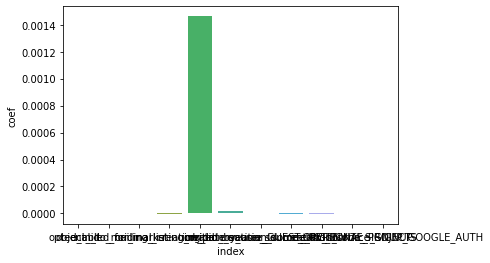

In [141]:
sns.barplot(x='index',y='coef', data=coef_df.reset_index())